In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    roc_curve, 
    roc_auc_score
)
import lightgbm as lgb
import seaborn as sns

* Carga de datos

In [23]:
df = pd.read_csv('../../../data/loan_dataset.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


* Exploracion inicial de datos

In [24]:
print("Estructura del Dataset:")
print(df.info())

print("\nResumen Estadístico:")
print(df.describe())

print("\nValores Faltantes:")
print(df.isnull().sum())

Estructura del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

Resumen Estadístico:
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_A

* Analisis estadistico y descriptivo

In [25]:
variables_categoricas = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
for var in variables_categoricas:
    print(f"\nDistribución de {var}:")
    print(df[var].value_counts(normalize=True))

# Variables numéricas
variables_numericas = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for var in variables_numericas:
    print(f"\nEstadísticas de {var}:")
    print(df[var].describe())


Distribución de Gender:
Gender
Male      0.813644
Female    0.186356
Name: proportion, dtype: float64

Distribución de Married:
Married
Yes    0.651391
No     0.348609
Name: proportion, dtype: float64

Distribución de Education:
Education
Graduate        0.781759
Not Graduate    0.218241
Name: proportion, dtype: float64

Distribución de Self_Employed:
Self_Employed
No     0.859107
Yes    0.140893
Name: proportion, dtype: float64

Distribución de Property_Area:
Property_Area
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: proportion, dtype: float64

Distribución de Loan_Status:
Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

Estadísticas de ApplicantIncome:
count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

Estadísticas de CoapplicantIncome:
count      614.000000
mean      16

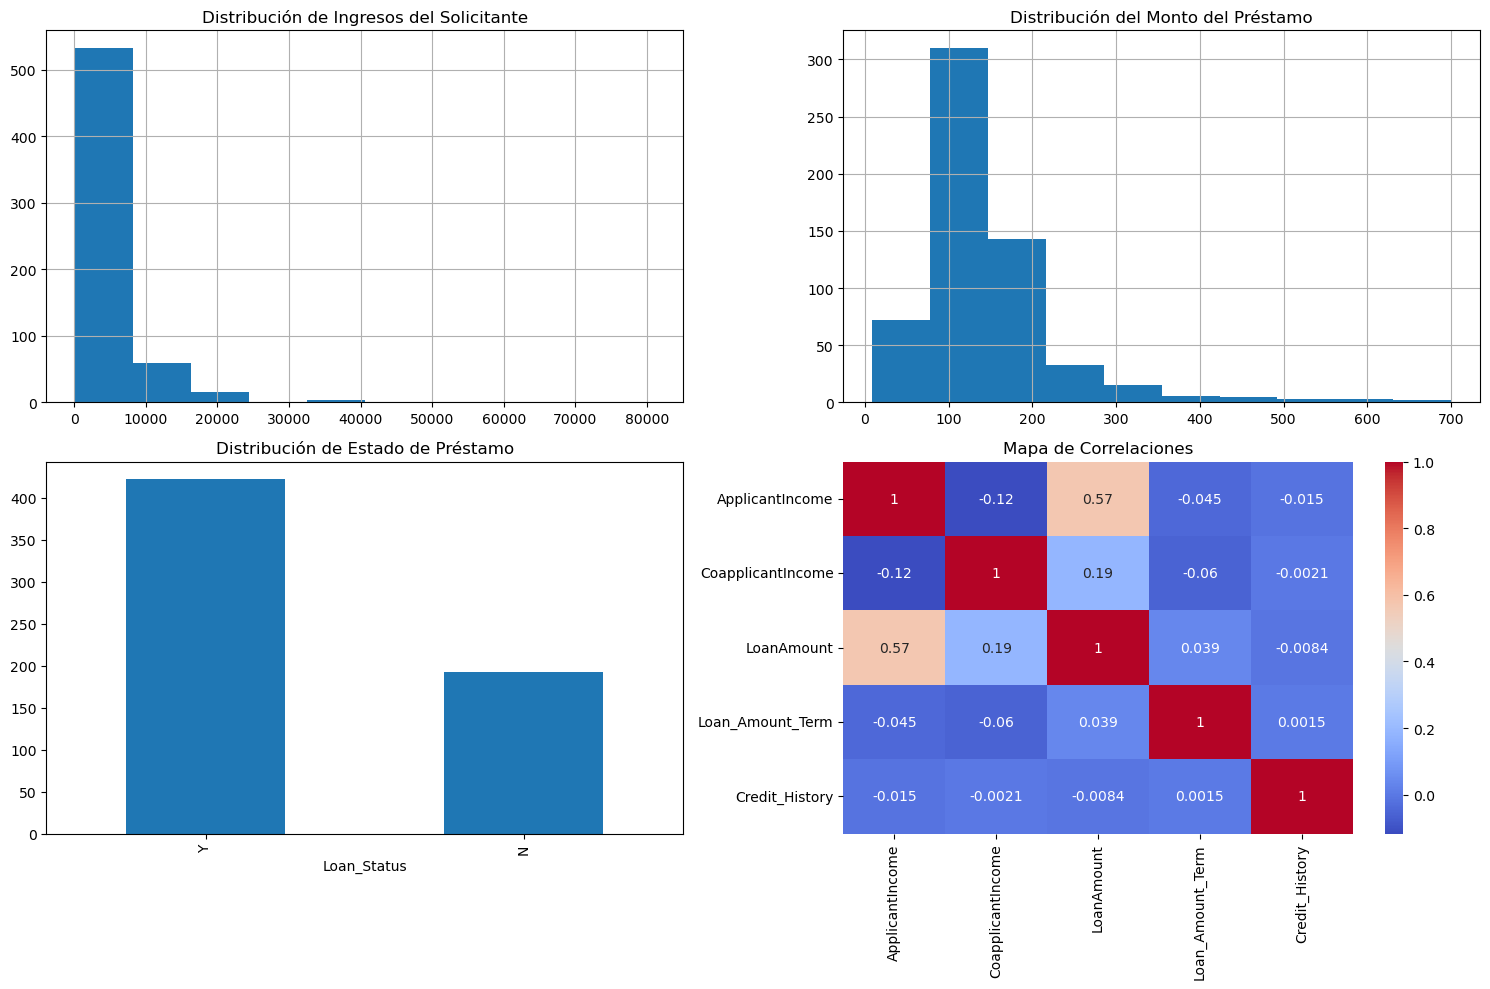

In [26]:
# Visualizaciones

plt.figure(figsize=(15, 10))

# Histogramas
plt.subplot(2, 2, 1)
df['ApplicantIncome'].hist()
plt.title('Distribución de Ingresos del Solicitante')

plt.subplot(2, 2, 2)
df['LoanAmount'].hist()
plt.title('Distribución del Monto del Préstamo')

# Gráfico de barras para variables categóricas
plt.subplot(2, 2, 3)
df['Loan_Status'].value_counts().plot(kind='bar')
plt.title('Distribución de Estado de Préstamo')

# Mapa de calor de correlaciones
plt.subplot(2, 2, 4)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Correlaciones')

plt.tight_layout()
plt.show()

* Preprocesamiento y Entrenamiento

In [27]:
def preprocesamiento(df):
    # Preparación de datos
    X = df.drop('Loan_Status', axis=1)
    y = df['Loan_Status'].map({'Y': 1, 'N': 0})
    
    # Columnas
    categoricas = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
    numericas = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
    
    # Preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numericas),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas)
        ])
    
    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, preprocessor

# Función para entrenar y evaluar modelos
def evaluar_modelo(X_train, X_test, y_train, y_test, preprocessor, parametros=None):
    # Configuración base del modelo
    if parametros is None:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', lgb.LGBMClassifier(random_state=42))
        ])
    else:
        # Modelo con hiperparámetros específicos
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', lgb.LGBMClassifier(random_state=42, **parametros))
        ])
    
    # Entrenamiento
    pipeline.fit(X_train, y_train)
    
    # Predicciones
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Métricas de evaluación
    resultados = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    return pipeline, resultados, cm, y_pred, y_pred_proba

# Preparación de datos
X_train, X_test, y_train, y_test, preprocessor = preprocesamiento(df)

# 1. Modelo Base (sin optimización)
modelo_base, resultados_base, cm_base, y_pred_base, y_pred_proba_base = evaluar_modelo(
    X_train, X_test, y_train, y_test, preprocessor
)

# 2. Modelo Optimizado (con hiperparámetros ajustados)
parametros_optimizados = {
    'n_estimators': 200,  # Más estimadores
    'learning_rate': 0.1,  # Tasa de aprendizaje moderada
    'max_depth': 5,  # Profundidad de árbol moderada
    'num_leaves': 31,  # Número de hojas
    'min_child_samples': 20  # Mínimo de muestras por hoja
}

modelo_optimizado, resultados_optimizado, cm_optimizado, y_pred_optimizado, y_pred_proba_optimizado = evaluar_modelo(
    X_train, X_test, y_train, y_test, preprocessor, parametros_optimizados
)

# 3. Comparación de Resultados
def comparar_modelos(resultados_base, resultados_optimizado):
    print("Comparación de Rendimiento de Modelos:")
    print("\nModelo Base:")
    for metrica, valor in resultados_base.items():
        print(f"{metrica.capitalize()}: {valor:.4f}")
    
    print("\nModelo Optimizado:")
    for metrica, valor in resultados_optimizado.items():
        print(f"{metrica.capitalize()}: {valor:.4f}")
    
    print("\nMejora Porcentual:")
    for metrica in resultados_base.keys():
        mejora = ((resultados_optimizado[metrica] - resultados_base[metrica]) / resultados_base[metrica]) * 100
        print(f"{metrica.capitalize()}: {mejora:.2f}%")

# 4. Visualización Comparativa
def visualizar_comparacion(y_test, y_pred_base, y_pred_optimizado, y_pred_proba_base, y_pred_proba_optimizado):
    plt.figure(figsize=(15, 5))
    
    # Curva ROC
    plt.subplot(1, 3, 1)
    fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_base)
    fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_proba_optimizado)
    
    plt.plot(fpr_base, tpr_base, label='Modelo Base')
    plt.plot(fpr_opt, tpr_opt, label='Modelo Optimizado')
    plt.title('Curva ROC')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()
    
    # Matriz de Confusión Base
    plt.subplot(1, 3, 2)
    sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Aprobado', 'Aprobado'],
                yticklabels=['No Aprobado', 'Aprobado'])
    plt.title('Matriz Confusión\nModelo Base')
    
    # Matriz de Confusión Optimizado
    plt.subplot(1, 3, 3)
    sns.heatmap(cm_optimizado, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Aprobado', 'Aprobado'],
                yticklabels=['No Aprobado', 'Aprobado'])
    plt.title('Matriz Confusión\nModelo Optimizado')
    
    plt.tight_layout()
    plt.show()

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Comparación de Rendimiento de Modelos:

Modelo Base:
Accuracy: 0.7642
Precision: 0.7629
Recall: 0.9250
F1_score: 0.8362
Roc_auc: 0.7730

Modelo Optimizado:
Accuracy: 0.7642
Precision: 0.7629
Recall: 0.9250
F1_score: 0.8362
Roc_auc: 0.7407

Mejora Porcentual:
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1_score: 0.00%
Roc_auc: -4.17%


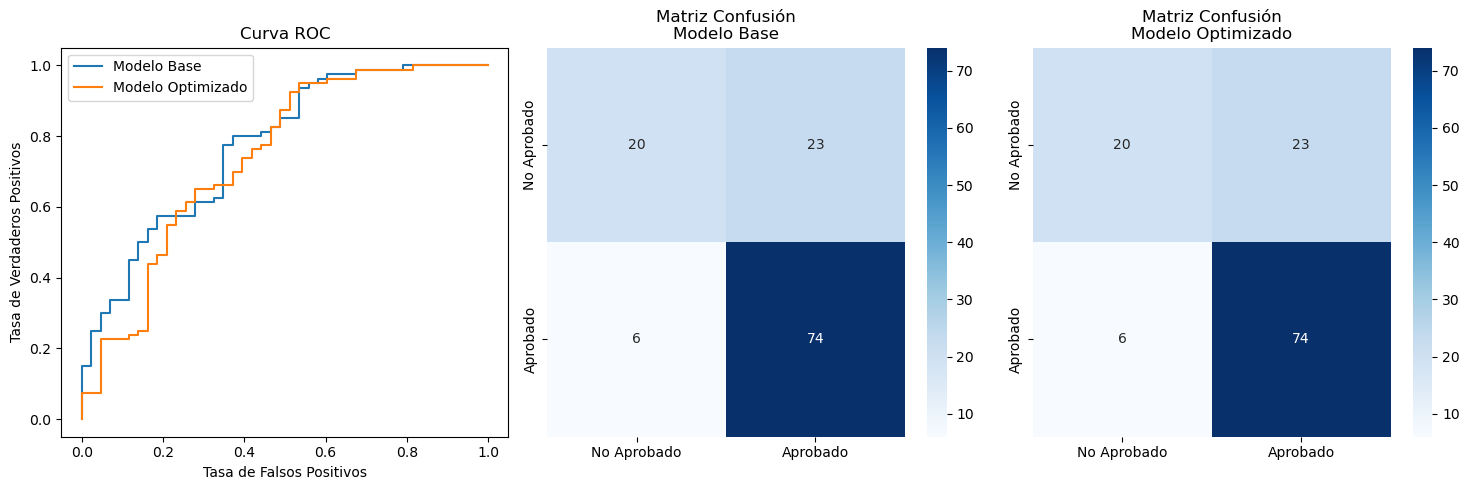


Informe de Clasificación - Modelo Base:
              precision    recall  f1-score   support

           0       0.77      0.47      0.58        43
           1       0.76      0.93      0.84        80

    accuracy                           0.76       123
   macro avg       0.77      0.70      0.71       123
weighted avg       0.77      0.76      0.75       123


Informe de Clasificación - Modelo Optimizado:
              precision    recall  f1-score   support

           0       0.77      0.47      0.58        43
           1       0.76      0.93      0.84        80

    accuracy                           0.76       123
   macro avg       0.77      0.70      0.71       123
weighted avg       0.77      0.76      0.75       123



In [28]:
comparar_modelos(resultados_base, resultados_optimizado)
visualizar_comparacion(y_test, y_pred_base, y_pred_optimizado, y_pred_proba_base, y_pred_proba_optimizado)

# Informe detallado de clasificación
print("\nInforme de Clasificación - Modelo Base:")
print(classification_report(y_test, y_pred_base))

print("\nInforme de Clasificación - Modelo Optimizado:")
print(classification_report(y_test, y_pred_optimizado))